any
[(20091, 1.0), (17735, 0.8827335622915733)]
[(20091, 1.0), (17735, 0.8827335622915733)]
[(20091, 1.0), (17735, 0.8827335622915733)]
[(20091, 1.0), (17735, 0.8827335622915733)]
[(20091, 1.0), (17735, 0.8827335622915733)]
[(20091, 1.0), (17735, 0.8827335622915733)]
Average performance
Sciddo B-F1  0.6289627316389302
Sciddo E-F1  0.6178474508073248
Sciddo B-Acc  0.75009539926667
Sciddo E-Acc  0.7690442627572596
-----
Pepr B-F1  0.5457742137784696
Pepr E-F1  0.5490959115179591
Pepr B-Acc  0.5766346456954191
Pepr E-Acc  0.580086458039658
inter
[(20091, 1.0), (12037, 0.5991239858643174)]
[(20091, 1.0), (12037, 0.5991239858643174)]
[(20091, 1.0), (12037, 0.5991239858643174)]
[(20091, 1.0), (12037, 0.5991239858643174)]
[(20091, 1.0), (12037, 0.5991239858643174)]
[(20091, 1.0), (12037, 0.5991239858643174)]
Average performance
Sciddo B-F1  0.6289627316389302
Sciddo E-F1  0.5466376776798264
Sciddo B-Acc  0.75009539926667
Sciddo E-Acc  0.7524438536733958
-----
Pepr B-F1  0.5457742137784696
Pep

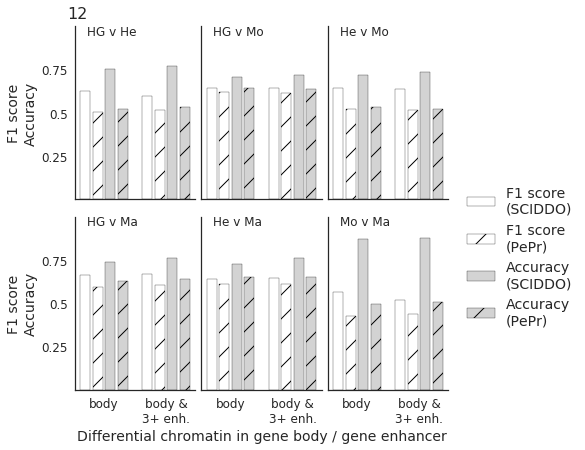

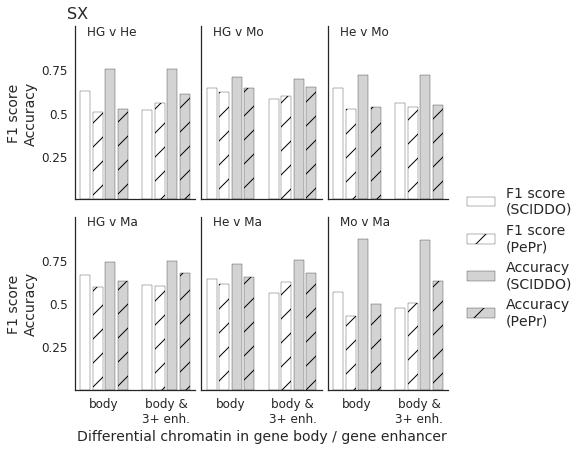

In [2]:
%matplotlib inline

import os as os
import csv as csv
import collections as collect
import operator as op
import itertools as itt
import pickle as pck
import time as ti
import json as js

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import sklearn as skl
import sklearn.metrics as sklm
import pandas as pd
from pandas.errors import EmptyDataError
import seaborn as sns

# What does this do?
# Plot performance bar charts for
# PePr and SCIDDO based on DE/stable
# gene overlaps with HSPs and DPs

date = '20180729'

run_hsp_pepr_perf = True

save_figures = True
diss_version = False

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

np.seterr('raise')

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

scorings = ['penem', 'ordem', 'penrep', 'ordrep']
segmentations = ['cmm18', 'ecs18', 'ecs10']

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

isect_root = os.path.join(fhgfs_base, 'bedtools', 'deep', 'pepr_locus_isect')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
genetrail_out = os.path.join(fhgfs_base, 'statediff/genetrail/input_lists')
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'


def compute_sciddo_performance(dataset, assoc_enh, enh_type='any'):
    
    enh_types = {'any': ('total_enh', 'total_hits'),
                 'intra': ('intra_enh', 'intra_hits'),
                 'inter': ('inter_enh', 'inter_hits')}
    enh_select, enh_hits = enh_types[enh_type]
    
    perf_scores = []
    applicable = []
    full_size = dataset.shape[0]
    for num_enh in assoc_enh:        
        subset = dataset.loc[dataset[enh_select] > num_enh, :].copy()
        
        subset['true'] = 0
        subset.loc[subset['is_de'] == 1, 'true'] = 1
            
        subset['pred'] = 0
        select_dc = np.logical_and(subset['body_hit'] > 0,
                                   subset[enh_hits] > num_enh)
        subset.loc[select_dc, 'pred'] = 1
        perf_scores.append(sklm.f1_score(subset['true'],
                                         subset['pred'],
                                         average='macro'))
        perf_scores.append(sklm.accuracy_score(subset['true'],
                                               subset['pred']))
        applicable.append((subset.shape[0], subset.shape[0] / dataset.shape[0]))
            
    return perf_scores, applicable


def compute_pepr_performance(dataset, assoc_enh, s1, s2, enh_type='any'):

    enh_types = {'any': ('total_enh', 'diff_total'),
                 'intra': ('intra_enh', 'diff_intra'),
                 'inter': ('inter_enh', 'diff_inter')}
    enh_select, enh_hits = enh_types[enh_type]
    
    # add diff body indicator
    s1 += '-H3K36me3'
    s2 += '-H3K36me3'
    dataset['body_diff'] = 0
    select_b0 = np.logical_and(dataset[s1] == 0, dataset[s2] > 0)
    select_b1 = np.logical_and(dataset[s1] > 0, dataset[s2] == 0)
    select_db = np.logical_or(select_b0, select_b1)
    dataset.loc[select_db, 'body_diff'] = 1
    
    perf_scores = []
    for num_enh in assoc_enh:
        subset = dataset.loc[dataset[enh_select] > num_enh, :].copy()
                
        subset['true'] = 0
        subset.loc[subset['is_de'] == 1, 'true'] = 1
    
        subset['pred'] = 0
        select_dc = np.logical_and(subset['body_diff'] > 0,
                                   subset[enh_hits] > num_enh)
        subset.loc[select_dc, 'pred'] = 1
        perf_scores.append(sklm.f1_score(subset['true'],
                                         subset['pred'],
                                         average='macro'))
        perf_scores.append(sklm.accuracy_score(subset['true'],
                                               subset['pred']))
    return perf_scores


def plot_perf_bar_charts(sciddo, pepr, enh_type, fkey, save_diss):
    print(enh_type)
    num_rows = 2
    num_cols = 3
    fig, axes = plt.subplots(figsize=fig_sizes['two_col']['square'],
                             nrows=num_rows, ncols=num_cols,
                             sharex=True, sharey=True)
    
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    leg = None
    
    comparisons = sorted(sciddo.keys())
    comp_axes = dict()
    for idx, c in enumerate(comparisons):
        q, r = divmod(idx, 2)
        comp_axes[c] = (r,q)
    
    sciddo_x = [1, 3, 6, 8]
    pepr_x = [2, 4, 7, 9]
    gene_enhancer = [-1, 2]
    bar_colors = []
    now, last = 'white', 'lightgrey'
    for _ in sciddo_x:
        bar_colors.extend(['white', 'lightgrey'])
        now, last = last, now
    edge_colors = ['black' if x == 'white' else 'black' for x in bar_colors]
    
    avg_sciddo = collect.defaultdict(list)
    avg_pepr = collect.defaultdict(list)
    perf_labels = ['b-f1', 'b-acc', 'e-f1', 'e-acc']
    
    for comp in comparisons:
        r, c = comp_axes[comp]
        s1, s2 = comp.split('_vs_')
        ax = axes[r, c]
        ax.set_ylim(0, 1)
        if r == 0 and c == 0 and not save_diss:
            tt = ax.set_title(fkey, fontsize=16)
            tt.set_position((0.025, 1.01))
        
        sciddo_y, target_cov = compute_sciddo_performance(sciddo[comp], gene_enhancer, enh_type)
        pepr_y = compute_pepr_performance(pepr[comp], gene_enhancer, s1, s2, enh_type)
        
        for s, l in zip(sciddo_y, perf_labels):
            avg_sciddo[l].append(s)
        for p, l in zip(pepr_y, perf_labels):
            avg_pepr[l].append(p)

        print(target_cov)
                
        ax.bar(sciddo_x, sciddo_y,
               label='SCIDDO',
               color=bar_colors,
               edgecolor=edge_colors,
               hatch='')
        
        ax.bar(pepr_x, pepr_y, label='PePr',
               color=bar_colors,
               edgecolor=edge_colors,
               hatch='/')
        
        ax.set_xticks([2.5, 7.5])
        ax.set_xticklabels(['body', 'body &\n{}+ enh.'.format(gene_enhancer[-1] + 1)],
                           fontsize=12)
        
        ax.set_yticks([0.25, 0.5, 0.75])
        ax.set_yticklabels(['0.25', '0.5', '0.75'], fontsize=12)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.text(0.1, 0.95, '{} v {}'.format(s1, s2),
                fontdict={'fontsize': 12}, transform=ax.transAxes)
        
        if c == 0:
            ax.set_ylabel('F1 score\nAccuracy', fontsize=14)
        
        if r == 1 and c == 1:
            ax.set_xlabel('Differential chromatin in gene body / gene enhancer', fontsize=14)
        
        if r == 1 and c == 2:
            leg_patches = []
            leg_patches.append(mpatches.Patch(facecolor='white', label='F1 score\n(SCIDDO)',
                                              hatch='', ec='black'))
            leg_patches.append(mpatches.Patch(facecolor='white', label='F1 score\n(PePr)',
                                              hatch='/', ec='black'))
            leg_patches.append(mpatches.Patch(facecolor='lightgrey', label='Accuracy\n(SCIDDO)',
                                              hatch='', ec='black'))
            leg_patches.append(mpatches.Patch(facecolor='lightgrey', label='Accuracy\n(PePr)',
                                              hatch='/', ec='black'))
            leg = ax.legend(handles=leg_patches,
                            bbox_to_anchor=(1.05, 1.25),
                            fontsize=14)

    assert leg is not None, 'Legend missing'
    
    print('Average performance')
    print('Sciddo B-F1 ', np.average(avg_sciddo['b-f1']))
    print('Sciddo E-F1 ', np.average(avg_sciddo['e-f1']))
    print('Sciddo B-Acc ', np.average(avg_sciddo['b-acc']))
    print('Sciddo E-Acc ', np.average(avg_sciddo['e-acc']))
    print('-----')
    print('Pepr B-F1 ', np.average(avg_pepr['b-f1']))
    print('Pepr E-F1 ', np.average(avg_pepr['e-f1']))
    print('Pepr B-Acc ', np.average(avg_pepr['b-acc']))
    print('Pepr E-Acc ', np.average(avg_pepr['e-acc']))
    
    print('=============')
    
    return fig, [leg]
            


def plot_hsp_pepr_perf():
    # use cached data from other notebooks
    hsp_ovl_cache = os.path.join(cache_dir, '20180729_plot_gene-enh-hsp_tpm-bin.h5')
    if not os.path.isfile(hsp_ovl_cache):
        raise RuntimeError('No cached data for HSP overlaps')
    pepr_ovl_cache = os.path.join(cache_dir, '20180729_plot_gene-enh-pepr_tpm-bin.h5')
    if not os.path.isfile(pepr_ovl_cache):
        raise RuntimeError('No cached data for PePr overlaps')

    for seg in segmentations:
        if seg != 'cmm18':
            continue
        for score in scorings:
            if score != 'penem':
                continue
            sciddo_data = dict()
            with pd.HDFStore(hsp_ovl_cache, 'r') as hdf:
                load_keys = sorted([k for k in hdf.keys() if seg in k and score in k])
                for k in load_keys:
                    comp = os.path.split(k)[-1]
                    if comp == 'Liver_vs_Blood':
                        continue
                    sciddo_data[comp] = hdf[k]
            pepr_data = dict()
            with pd.HDFStore(pepr_ovl_cache, 'r') as hdf:
                for k in hdf.keys():
                    comp = os.path.split(k)[-1]
                    pepr_data[comp] = hdf[k]
            for fk, enh_type in zip(['12', 'SX'], ['any', 'inter']):
                fig, exart = plot_perf_bar_charts(sciddo_data, pepr_data, enh_type, fk, diss_version)
                if save_figures:
                    outname = 'fig_{}_hsp_pepr_perf_enh-{}_{}_{}'.format(fk, enh_type, seg, score)
                    if fk.startswith('S'):
                        out_folder = fig_supp
                    else:
                        out_folder = fig_main
                        
                    if diss_version:
                        out_folder = fig_diss

                    out_pdf = os.path.join(out_folder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    if not diss_version:
                        out_png = os.path.join(out_folder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                
    return



if run_hsp_pepr_perf:
    plot_hsp_pepr_perf()
